In [1]:
import tensorflow as tf
import os
import numpy as np
import glob
from sklearn import utils as sk_utils


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# define image size
IMG_WIDTH = 256
IMG_HEIGHT = 192
IMG_CHANNELS = 3

In [4]:
def load_image(file_path, is_x=False):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image)
    
    if is_x:
        image = tf.image.resize(image, (IMG_HEIGHT,IMG_WIDTH), method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # Normalize the image
    else:
        image = tf.image.resize(image, (IMG_HEIGHT,IMG_WIDTH), method='nearest', antialias=True)
    return image

## Load Training set

In [5]:
import numpy as np
import cv2
import tensorflow as tf

def add_synthetic_fog(image, beta=0.7, A=255):
    """
    Adds synthetic fog to an image using a simplified Koschmieder model.
    
    Parameters:
        image: Input image in BGR format.
        beta: Fog density parameter (larger values produce denser fog).
        A: Atmospheric light intensity (255 gives white fog).
        
    Returns:
        Foggy image.
    """
    # Convert image to float32 for calculations
    image_float = image.astype(np.float32)
    
    # Compute a uniform transmission factor t = exp(-beta)
    t = np.exp(-beta)
    
    # Create an atmospheric light image (same shape as the input)
    fog_layer = np.full(image.shape, A, dtype=np.float32)
    
    # Blend the original image with the fog layer
    foggy_image = image_float * t + fog_layer * (1 - t)
    
    # Apply Gaussian blur to simulate light scattering
    foggy_image = cv2.GaussianBlur(foggy_image, (5, 5), 0)
    
    # Clip values and convert back to uint8
    foggy_image = np.clip(foggy_image, 0, 255).astype(np.uint8)
    return foggy_image

def apply_blur(image, kernel_size=5):
    """
    Applies Gaussian blur to an image.
    
    Parameters:
        image: Input image.
        kernel_size: Size of the blurring kernel.
        
    Returns:
        Blurred image.
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def enhance_contrast(image, alpha=1.5, beta=0):
    """
    Enhances the contrast of an image.
    
    Parameters:
        image: Input image.
        alpha: Contrast control (1.0-3.0).
        beta: Brightness control (0-100).
        
    Returns:
        Contrast-enhanced image.
    """
    # Apply the contrast adjustment
    enhanced = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return enhanced

def random_brightness(image, max_delta=0.2):
    """
    Randomly adjusts the brightness of an image.
    
    Parameters:
        image: Input image.
        max_delta: Maximum brightness adjustment.
        
    Returns:
        Brightness-adjusted image.
    """
    return tf.image.random_brightness(image, max_delta).numpy()

def augment_data(image, mask, augment_probability=0.5):
    """
    Applies random data augmentation to an image and its mask.
    
    Parameters:
        image: Input image.
        mask: Corresponding segmentation mask.
        augment_probability: Probability of applying each augmentation.
        
    Returns:
        Augmented image and mask.
    """
    aug_image = image.copy()
    
    # Only apply augmentations to the image, not the mask
    if np.random.random() < augment_probability:
        # Random fog
        fog_density = np.random.uniform(0.3, 0.8)
        aug_image = add_synthetic_fog(aug_image, beta=fog_density)
    
    if np.random.random() < augment_probability:
        # Random blur
        kernel_size = np.random.choice([3, 5, 7])
        aug_image = apply_blur(aug_image, kernel_size)
    
    if np.random.random() < augment_probability:
        # Random contrast enhancement
        alpha = np.random.uniform(1.0, 2.0)
        aug_image = enhance_contrast(aug_image, alpha=alpha)
    
    if np.random.random() < augment_probability:
        # Random brightness
        aug_image = random_brightness(aug_image, max_delta=0.3)
    
    # Common augmentations that apply to both image and mask
    if np.random.random() < augment_probability:
        # Random horizontal flip
        if np.random.random() < 0.5:
            aug_image = cv2.flip(aug_image, 1)
            mask = cv2.flip(mask, 1)
    
    return aug_image, mask

# Function to augment the entire dataset
def create_augmented_dataset(X_train, Y_train, augmentation_factor=1):
    """
    Creates an augmented dataset by applying various augmentations.
    
    Parameters:
        X_train: Original training images.
        Y_train: Original training masks.
        augmentation_factor: How many augmented versions to create for each image.
        
    Returns:
        Augmented images and masks concatenated with the original data.
    """
    aug_images = []
    aug_masks = []
    
    for i in range(len(X_train)):
        for _ in range(augmentation_factor):
            # Convert to uint8 for OpenCV operations
            img = (X_train[i] * 255).astype(np.uint8)
            mask = Y_train[i].astype(np.uint8)
            
            # Apply augmentation
            aug_img, aug_mask = augment_data(img, mask)
            
            # Convert back to float32 and normalize
            aug_img = aug_img.astype(np.float32) / 255.0
            
            aug_images.append(aug_img)
            aug_masks.append(aug_mask)
        
        # Print progress
        if (i+1) % 500 == 0:
            print(f"Augmented {i+1}/{len(X_train)} images")
    
    # Concatenate with original data
    X_augmented = np.concatenate([X_train, np.array(aug_images)], axis=0)
    Y_augmented = np.concatenate([Y_train, np.array(aug_masks)], axis=0)
    
    return X_augmented, Y_augmented

In [ ]:
image_paths = sorted(glob.glob(TRAIN_PATH))
mask_paths = sorted(glob.glob(MASK_TRAIN))
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

X_train = []
Y_train = []
X_train_augmented = []
Y_train_augmented = []

for x, y in zip(image_paths, mask_paths):
    # Load original image and mask
    img = load_image(x, True)
    mask = load_image(y)
    
    X_train.append(img)
    Y_train.append(mask)
    
    # Create augmented versions
    # Convert to uint8 for OpenCV operations
    img_uint8 = (img.numpy() * 255).astype(np.uint8)
    mask_uint8 = mask.numpy().astype(np.uint8)
    
    # Apply fog augmentation to the image only (not the mask)
    img_fog = add_synthetic_fog(img_uint8)
    
    # Convert back to float32 and normalize
    img_fog = img_fog.astype(np.float32) / 255.0
    
    # Keep the original mask shape but apply horizontal flip to both if needed
    if np.random.random() < 0.5:
        img_fog = cv2.flip(img_fog, 1)
        mask_fog = cv2.flip(mask_uint8, 1)
    else:
        mask_fog = mask_uint8.copy()
    
    # Ensure mask has the correct shape (add channel dim if needed)
    if len(mask_fog.shape) == 2:
        mask_fog = mask_fog.reshape(mask_fog.shape[0], mask_fog.shape[1], 1)
    
    X_train_augmented.append(img_fog)
    Y_train_augmented.append(mask_fog)
    
    if len(X_train) % 500 == 0:
        print(len(X_train), 'original data points loaded!')
        print(len(X_train_augmented), 'augmented data points created!')
else:
    print(len(X_train), 'original data points loaded in total!')
    print(len(X_train_augmented), 'augmented data points created in total!')

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)

# Combine original and augmented data
X_train_combined = np.concatenate([X_train, X_train_augmented], axis=0)
Y_train_combined = np.concatenate([Y_train, Y_train_augmented], axis=0)

# 255 is representing unknown objects
Y_train_combined[Y_train_combined == 255] = 19

# Shuffle the combined dataset
indices = np.random.permutation(len(X_train_combined))
X_train = X_train_combined[indices]
Y_train = Y_train_combined[indices]

print('Final training dataset shape:')
print('X train:', X_train.shape)
print('Y train:', Y_train.shape)

500 original data points loaded!
500 augmented data points created!
1000 original data points loaded!
1000 augmented data points created!
1500 original data points loaded!
1500 augmented data points created!
2000 original data points loaded!
2000 augmented data points created!
2500 original data points loaded!
2500 augmented data points created!
3000 original data points loaded!
3000 augmented data points created!
3500 original data points loaded!
3500 augmented data points created!
4000 original data points loaded!
4000 augmented data points created!
4500 original data points loaded!
4500 augmented data points created!
5000 original data points loaded!
5000 augmented data points created!
5500 original data points loaded!
5500 augmented data points created!
6000 original data points loaded!
6000 augmented data points created!
6500 original data points loaded!
6500 augmented data points created!
7000 original data points loaded!
7000 augmented data points created!
7000 original data poi

## Model Architecture

In [7]:
dr = 0.3

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, Reshape, Lambda

def DeepLabV3(num_classes, input_shape):
    inputs = Input(shape=input_shape)

    # Backbone: Pre-trained ResNet101
    backbone = ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp1 = Conv2D(256, (1, 1), padding="same", dilation_rate=1, activation="relu")(backbone.output)
    aspp2 = Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(backbone.output)
    aspp3 = Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(backbone.output)
    aspp4 = Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(backbone.output)

    # Global Average Pooling
    global_avg = GlobalAveragePooling2D()(backbone.output)
    global_avg = Reshape((1, 1, global_avg.shape[-1]))(global_avg)
    global_avg = Conv2D(256, (1, 1), padding="same", activation="relu")(global_avg)
    
    # Extract static shape of aspp1 for resizing
    aspp1_shape = tf.keras.backend.int_shape(aspp1)
    target_height = aspp1_shape[1]  # e.g., 12 if known
    target_width = aspp1_shape[2]   # e.g., 16 if known

    # Use Lambda layer with explicit output_shape to resize global_avg
    global_avg = Lambda(
        lambda x: tf.image.resize(x, (target_height, target_width), method='bilinear'),
        output_shape=(target_height, target_width, 256)
    )(global_avg)

    # Concatenate all ASPP features
    aspp_concat = Concatenate()([aspp1, aspp2, aspp3, aspp4, global_avg])
    aspp_output = Conv2D(256, (1, 1), padding="same", activation="relu")(aspp_concat)

    # Decoder with skip connection
    decoder_input = Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(aspp_output)
    skip_connection = backbone.get_layer("conv2_block3_out").output  # Verify that this layer exists

    # Resize decoder_input to match skip_connection dimensions (using constant upsampling factor)
    decoder_input_resized = UpSampling2D(size=(4, 4), interpolation="bilinear")(decoder_input)
    decoder_merged = Concatenate()([decoder_input_resized, skip_connection])
    decoder_output = Conv2D(256, (3, 3), padding="same", activation="relu")(decoder_merged)

    # Final Upsampling and Output
    final_output = Conv2DTranspose(num_classes, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="softmax")(decoder_output)
    final_output = UpSampling2D(size=(2, 2), interpolation="bilinear")(final_output)
    final_output = Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(final_output)

    # Build the model
    model = Model(inputs, final_output)
    return model

# Define input parameters
IMG_HEIGHT = 192
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Initialize and compile the model
model = DeepLabV3(num_classes=20, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [37]:
import tensorflow as tf
import numpy as np
from glob import glob
import random
import os

# Load all file paths
image_paths = sorted(glob(TRAIN_PATH))
mask_paths = sorted(glob(MASK_TRAIN))

# Sample 50% of the data
half_data_size = len(image_paths) // 2
selected_indices = np.random.choice(len(image_paths), half_data_size, replace=False)
image_paths = [image_paths[i] for i in selected_indices]
mask_paths = [mask_paths[i] for i in selected_indices]

print(f"Dataset reduced to {len(image_paths)} samples")

# Train-Validation Split (90-10)
val_split = 0.4
val_size = int(len(image_paths) * val_split)

indices = np.random.permutation(len(image_paths))
train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_images = [image_paths[i] for i in train_indices]
train_masks = [mask_paths[i] for i in train_indices]
val_images = [image_paths[i] for i in val_indices]
val_masks = [mask_paths[i] for i in val_indices]

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")

def load_and_preprocess(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    # Resize to match model input: height=192, width=256
    img = tf.image.resize(img, (192, 256))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (192, 256), method='nearest')
    mask = tf.cast(mask, tf.int32)
    mask = tf.where(mask == 255, 19, mask)  # Handle unknown objects
    return img, mask

# Optional data augmentation
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

# Dataset builder
def create_dataset(images, masks, batch_size=16, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(1024) if training else dataset
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 16
train_dataset = create_dataset(train_images, train_masks, batch_size, training=True)
val_dataset = create_dataset(val_images, val_masks, batch_size, training=False)

# Calculate steps
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_best.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
]



# 🚀 Model Training (Assuming 'model' is defined)
results = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Dataset reduced to 3500 samples
Training set: 2100 images
Validation set: 1400 images
Epoch 1/100


W0000 00:00:1742754516.900455     141 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-03-23 18:28:54.976307: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=1,k3=0} for conv (f32[2304,2048,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2304,256,1,1]{3,2,1,0}, f32[256,2048,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-03-23 18:28:55.168325: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.19213562s
Trying algorithm eng25{k2=1,k3=0} for conv (f32[2304,2048,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2304,256,1,1]{3,2,1,0}, f32[256,2048,3,3]{

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2350 - loss: 2.7339

W0000 00:00:1742754614.086903     140 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


131/131 ━━━━━━━━━━━━━━━━━━━━ 174s 421ms/step - accuracy: 0.2353 - loss: 2.7332 - val_accuracy: 0.2399 - val_loss: 2.6387 - learning_rate: 0.0010
Epoch 2/100


W0000 00:00:1742754631.368089     139 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1742754674.244844     139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_30', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memor

  1/131 ━━━━━━━━━━━━━━━━━━━━ 1:42:58 48s/step - accuracy: 0.2248 - loss: 2.5230

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1742754675.687756     141 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 106ms/step - accuracy: 0.2248 - loss: 2.5230 - val_accuracy: 0.2333 - val_loss: 2.6334 - learning_rate: 0.0010
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 372ms/step - accuracy: 0.3365 - loss: 2.4393 - val_accuracy: 0.3662 - val_loss: 2.3135 - learning_rate: 0.0010
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3216 - loss: 2.3328 - val_accuracy: 0.3338 - val_loss: 2.3090 - learning_rate: 0.0010
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - accuracy: 0.3873 - loss: 2.2246 - val_accuracy: 0.2911 - val_loss: 2.2216 - learning_rate: 0.0010
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.3699 - loss: 2.1589 - val_accuracy: 0.2905 - val_loss: 2.2238 - learning_rate: 0.0010
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step - accuracy: 0.3861 - loss: 2.0631 - val_accuracy: 0.3607 - val_loss: 2.0519 - learning_rate: 0.0010
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4585 - loss

In [40]:
model.save('./DeepLabV3.h5')

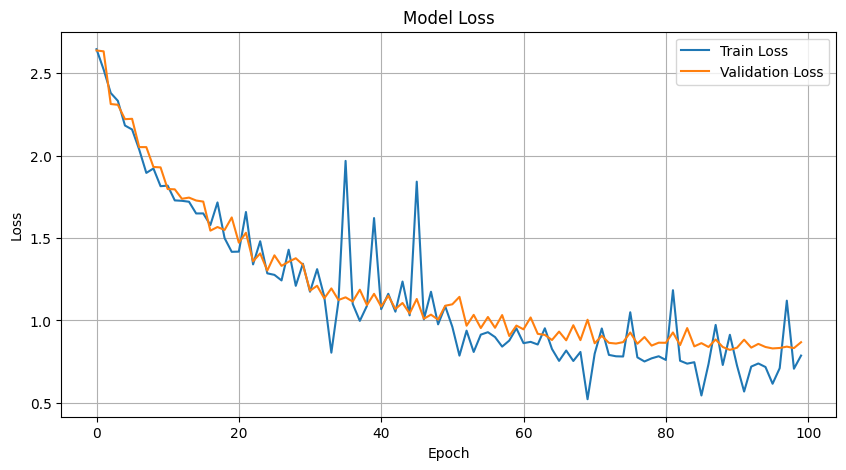

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

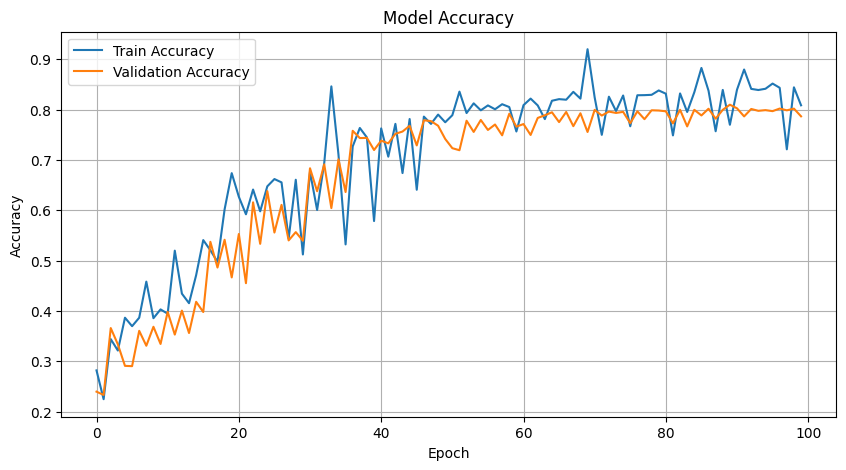

In [42]:
# Plot training & validation accuracy (if you save it during fitting)
plt.figure(figsize=(10, 5))
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()
